# Проект: "ТелеДом"

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи.

**Оператор предоставляет два основных типа услуг:**
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Цель проекта:** создать модель для прогноза оттока клиентов.

**План проекта:**
1. Загрузка данных.
2. Исследовательский анализ и предобработка данных.
3. Объединение данных.
4. Исследовательский анализ и предобработка данных объединённого датафрейма.
5. Подготовка данных.
6. Обучение моделей машинного обучения.
7. Выбор лучшей модели.
8. Общий вывод и рекомендации заказчику.

# 1. Загрузка данных

In [ ]:
!pip install phik
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

from datetime import datetime
from matplotlib.patches import Rectangle
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             roc_curve,
                             classification_report)
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   StandardScaler,
                                   RobustScaler)

In [ ]:
contract = pd.read_csv('/datasets/contract_new.csv')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
personal = pd.read_csv('/datasets/personal_new.csv')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
internet = pd.read_csv('/datasets/internet_new.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
phone = pd.read_csv('/datasets/phone_new.csv')
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


# 2. Исследовательский анализ и предобработка данных

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.duplicated().sum()

0

In [ ]:
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

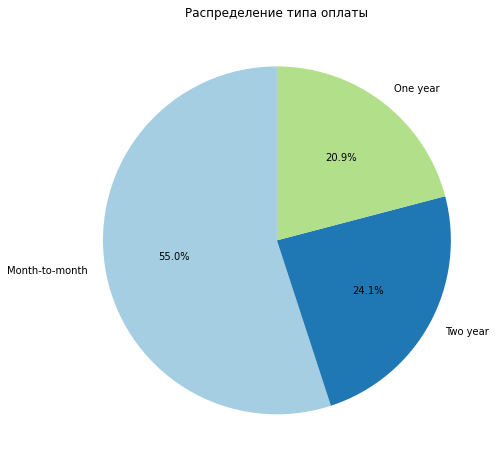

In [ ]:
counts = contract['Type'].value_counts()
counts.plot.pie(autopct='%1.1f%%',
              startangle=90,
              colors=plt.cm.Paired.colors,
              figsize=(8, 8)
             )
plt.title('Распределение типа оплаты')
plt.ylabel('')
plt.show()

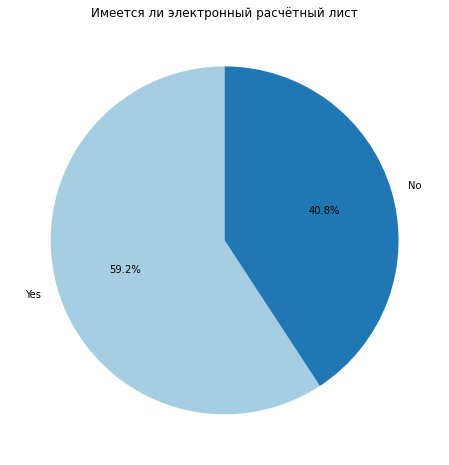

In [ ]:
counts = contract['PaperlessBilling'].value_counts()
counts.plot.pie(autopct='%1.1f%%',
              startangle=90,
              colors=plt.cm.Paired.colors,
              figsize=(8, 8)
             )
plt.title('Имеется ли электронный расчётный лист')
plt.ylabel('')
plt.show()

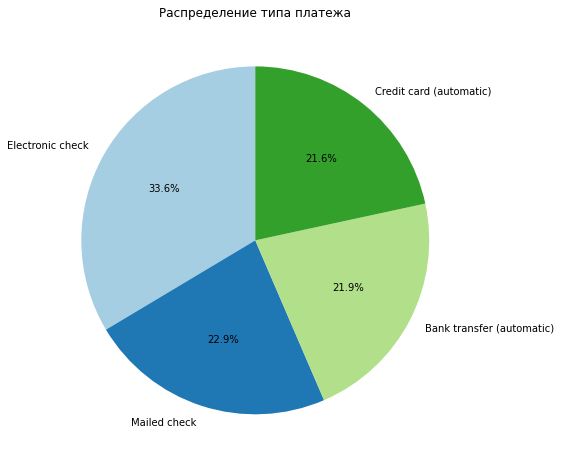

In [ ]:
counts = contract['PaymentMethod'].value_counts()
counts.plot.pie(autopct='%1.1f%%',
              startangle=90,
              colors=plt.cm.Paired.colors,
              figsize=(8, 8)
             )
plt.title('Распределение типа платежа')
plt.ylabel('')
plt.show()

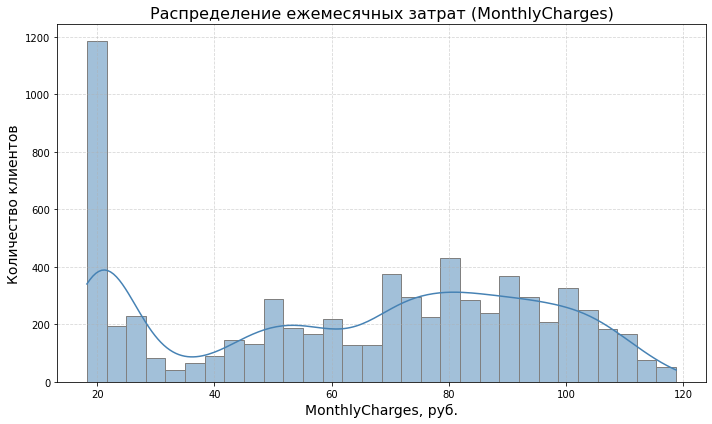

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(contract['MonthlyCharges'], bins=30, kde=True, color='steelblue', edgecolor='gray')

plt.title('Распределение ежемесячных затрат (MonthlyCharges)', fontsize=16)
plt.xlabel('MonthlyCharges, руб.', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
contract['TotalCharges'].isnull().sum()

0

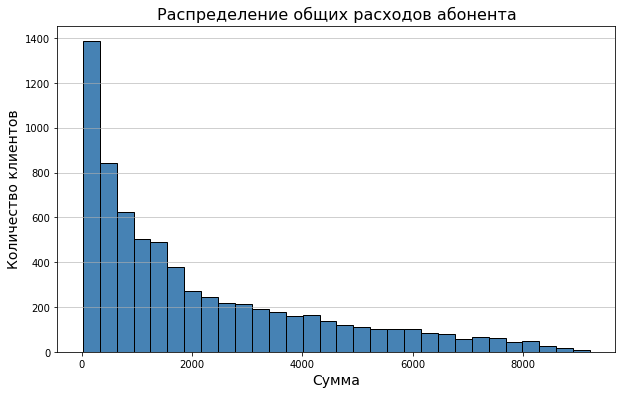

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

plt.figure(figsize=(10, 6))
plt.hist(contract['TotalCharges'], bins=30, color='steelblue', edgecolor='black')
plt.title('Распределение общих расходов абонента', fontsize=16)
plt.xlabel('Сумма', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.duplicated().sum()

0

In [ ]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

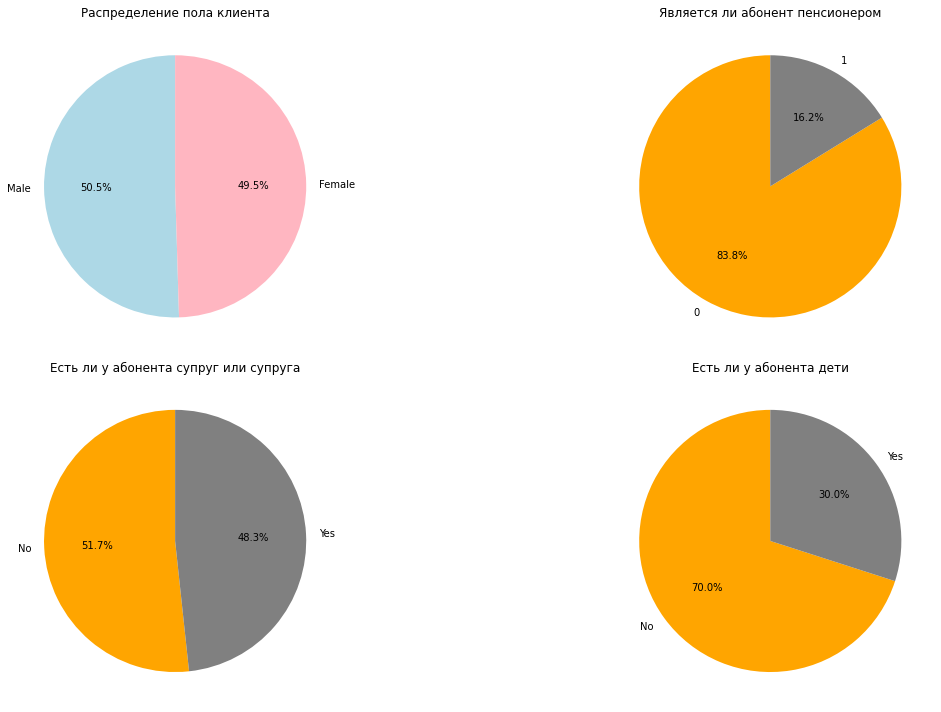

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

personal['gender'].value_counts().plot.pie(ax=axes[0, 0], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
axes[0, 0].set_title('Распределение пола клиента')
axes[0, 0].set_ylabel('')

personal['SeniorCitizen'].value_counts().plot.pie(ax=axes[0, 1], autopct='%1.1f%%', startangle=90, colors=['orange', 'gray'])
axes[0, 1].set_title('Является ли абонент пенсионером')
axes[0, 1].set_ylabel('')

personal['Partner'].value_counts().plot.pie(ax=axes[1, 0], autopct='%1.1f%%', startangle=90, colors=['orange', 'gray'])
axes[1, 0].set_title('Есть ли у абонента супруг или супруга')
axes[1, 0].set_ylabel('')

personal['Dependents'].value_counts().plot.pie(ax=axes[1, 1], autopct='%1.1f%%', startangle=90, colors=['orange', 'gray'])
axes[1, 1].set_title('Есть ли у абонента дети')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.duplicated().sum()

0

In [ ]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

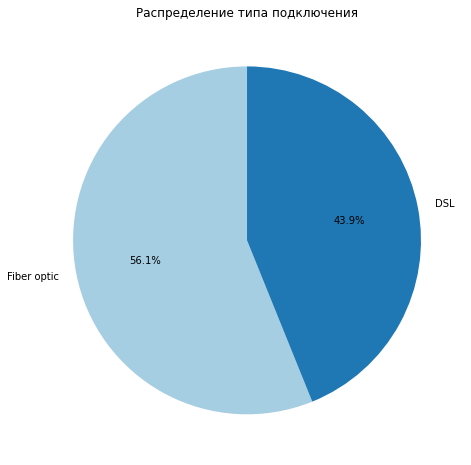

In [ ]:
counts = internet['InternetService'].value_counts()
counts.plot.pie(autopct='%1.1f%%',
              startangle=90,
              colors=plt.cm.Paired.colors,
              figsize=(8, 8)
             )
plt.title('Распределение типа подключения')
plt.ylabel('')
plt.show()

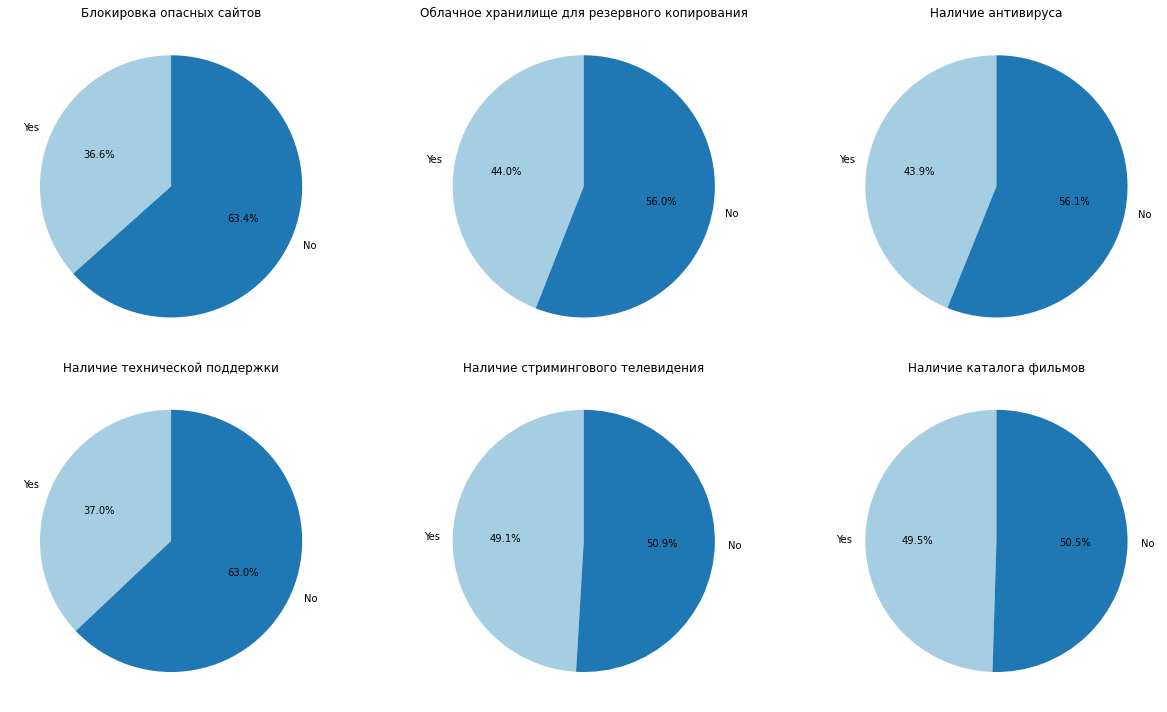

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

columns = [
    ('OnlineSecurity', 'Блокировка опасных сайтов'),
    ('OnlineBackup', 'Облачное хранилище для резервного копирования'),
    ('DeviceProtection', 'Наличие антивируса'),
    ('TechSupport', 'Наличие технической поддержки'),
    ('StreamingTV', 'Наличие стримингового телевидения'),
    ('StreamingMovies', 'Наличие каталога фильмов')
]

for i, (col, title) in enumerate(columns):
    row = i // 3
    col_idx = i % 3
    data = internet[col].value_counts().sort_values()

    data.plot.pie(
        ax=axes[row, col_idx],
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors,
        legend=False
    )
    axes[row, col_idx].set_title(title)
    axes[row, col_idx].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.duplicated().sum()

0

In [ ]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

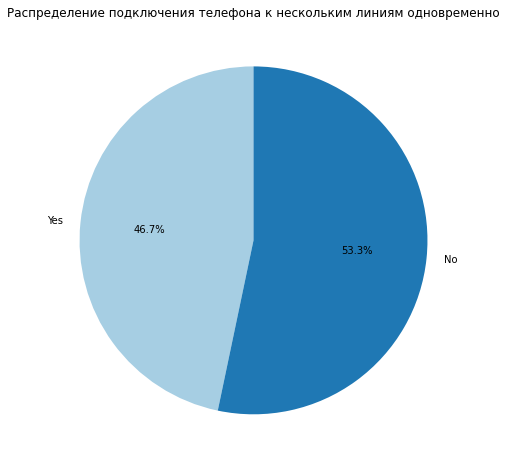

In [ ]:
data = phone['MultipleLines'].value_counts().sort_values()
data.plot.pie(autopct='%1.1f%%',
              startangle=90,
              colors=plt.cm.Paired.colors,
              figsize=(8, 8)
             )
plt.title('Распределение подключения телефона к нескольким линиям одновременно')
plt.ylabel('')
plt.show()

**Выводы по каждому столбцу четырёх датасетов:**

*contract*
- `BeginDate` и `EndDate:` пик заключения и расторжения договоров выпал на 2019 год.;             
- `Type:` распределение сипа договора оплаты: месячный договор (Month-to-month) — встречается у 55% клиентов,
годовой договор (One year) — заключён у 20,9% клиентов, двухлетний договор (Two year) — выбирают 24,1% абонентов;   
- `PaperlessBilling:`у большего числа абонентов (59,2%) имеется расчётный лист;    
- `PaymentMethod:`самым распространённым является Electronic check — им пользуются 33,6% клиентов, примерно равное количество абонентов выбирает автоматические платежи (Bank transfer (automatic) — 21,9% и Credit card (automatic) — 21,6%), остальные 22,9% оплачивают услуги посредством Mailed check;       
- `MonthlyCharges:`распределение ежемесячных затратрат показывает, что траты большего количество клиентов близко к нулю;      
- `TotalCharges:` пик количества клиентов выпадает на минимальные траты или же их отсутствие.   

*personal*
- `gender:` распределение мужчин и женщин, которые являются абонентами "ТелеДом", соответственно, равно 50,5% и 49,5%;
- `SeniorCitizen:`относительно небольшая часть клиентов — 16,2% — являются пенсионерами;
- `Partner:` более половины абонентов — 51,7% — не состоят в браке;
- `Dependents:` у 70% клиентов нет детей.

*internet*
- `InternetService:`распределение типа подключения показывает, что Fiber optic = 56,1% и DSL = 43,9%;
- `OnlineSecurity:`большая часть опасных сайтов (63,4%) не блокируется;
- `OnlineBackup :`у абонентов чаще (56%) не имеется облачного хранилища;
- `DeviceProtection :`антивирус установлен почти у половины клиентов (43,9%);
- `TechSupport :`абоненты чаще не пользовались технической поддержкой (63%);
- `StreamingTV :`49,1% клиентов имеют его в наличии, в то время как у 50,9% — его отсутствует;
- `StreamingMovies:`49,5% абонентов имеют доступ к каталогу фильмов, а у 50,5% его отсутствует.

*phone*
- `MultipleLines:` абонентов, которые подключили телефон к нескольким линиям одновременно, чуть меньше и составляет 46,7%.

# 3. Объединение данных

In [ ]:
df = contract.merge(personal, on = 'customerID')
df = df.merge(internet, on = 'customerID', how = 'left')
df = df.merge(phone, on = 'customerID', how = 'left')
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [ ]:
df.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

# 4. Исследовательский анализ и предобработка данных объединённого датафрейма

In [ ]:
print(list(df.columns))

['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [ ]:
df = df.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate':'end_date',
    'Type':'type',
    'PaperlessBilling':'paperless_billing',
    'PaymentMethod':'payment_method',
    'MonthlyCharges':'monthly_charges',
    'TotalCharges':'total_charges',
    'SeniorCitizen':'senior_citizen',
    'Partner':'partner',
    'Dependents':'dependents',
    'InternetService':'internet_service',
    'OnlineSecurity':'online_security',
    'OnlineBackup':'online_backup',
    'DeviceProtection':'device_protection',
    'TechSupport':'tech_support',
    'StreamingTV':'streaming_tv',
    'StreamingMovies':'streaming_movies',
    'MultipleLines':'multiple_lines'
})

print(list(df.columns))

['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


При объединении таблиц образовались пропуски. Это связано с тем, что не все клиенты используют обы пакета услуг. Например, клиенты, использующие только телефон, скорее всего не нуждаются в дополнительных услугах интернета.

Сделаем замену пропусков с привязкой к типу основного пакета:
- "T" означает что данные отсутствуют и пакет используется с телефонией
- "I" означает, что данные отсутствуют и пакет используется с интернетом

In [ ]:
i = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
t = ['multiple_lines']
df[t] = df[t].fillna('T')
df[i] = df[i].fillna('I')

In [ ]:
df['active_contract'] = 1
df.loc[df['end_date'] == 'No', 'active_contract'] = 0

Информация о договорах актуальна на 1 февраля 2020 года, поэтому в столбце begin_date дата 2020-02-01 является конечным месяцем. Клиенты только заключили договор, но месяц ещё не закончился. Следовательно, можно поставить 0 и привести к типу float64.

In [ ]:
df['begin_date'] = pd.to_datetime(
    df['begin_date'],
    format='%Y-%m-%d'
)

df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01'
df['end_date'] = pd.to_datetime(
    df['end_date'],
    format='%Y-%m-%d'
)

df['duration_contract'] = (df['end_date'] - df['begin_date']).dt.components.days
df = df.drop(['begin_date', 'end_date'], axis=1)

In [ ]:
df.loc[df['total_charges'] == ' ', 'total_charges'] = 0
df['total_charges'] = df['total_charges'].astype('float64')

In [ ]:
df['senior_citizen'] = df['senior_citizen'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        7043 non-null   object  
 1   type               7043 non-null   object  
 2   paperless_billing  7043 non-null   object  
 3   payment_method     7043 non-null   object  
 4   monthly_charges    7043 non-null   float64 
 5   total_charges      7032 non-null   float64 
 6   gender             7043 non-null   object  
 7   senior_citizen     7043 non-null   category
 8   partner            7043 non-null   object  
 9   dependents         7043 non-null   object  
 10  internet_service   7043 non-null   object  
 11  online_security    7043 non-null   object  
 12  online_backup      7043 non-null   object  
 13  device_protection  7043 non-null   object  
 14  tech_support       7043 non-null   object  
 15  streaming_tv       7043 non-null   object  
 16  stream

In [ ]:
df.shape

(7043, 20)

In [ ]:
df.isna().sum()

customer_id           0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
active_contract       0
duration_contract     0
dtype: int64

In [ ]:
df['total_charges'].fillna(df['total_charges'].median(), inplace=True)
df.isna().sum()

customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
active_contract      0
duration_contract    0
dtype: int64

In [ ]:
print(df['active_contract'].dtypes)

int64


In [ ]:
df['active_contract'] = df['active_contract'].astype(float)
print(df['active_contract'].dtypes)

float64


In [ ]:
df.isna().sum()

customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
active_contract      0
duration_contract    0
dtype: int64

In [ ]:
df.describe()

,monthly_charges,total_charges,active_contract,duration_contract
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2117.413982,0.156325,898.555729
std,30.090047,2111.306354,0.363189,683.130510
min,18.250000,19.050000,0.000000,0.000000
25%,35.500000,440.495000,0.000000,276.000000
50%,70.350000,1345.275000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


In [ ]:
df.set_index('customer_id', inplace = True)

In [ ]:
interval_cols = ['monthly_charges',
                 'total_charges',
                 'duration_contract'
                ]

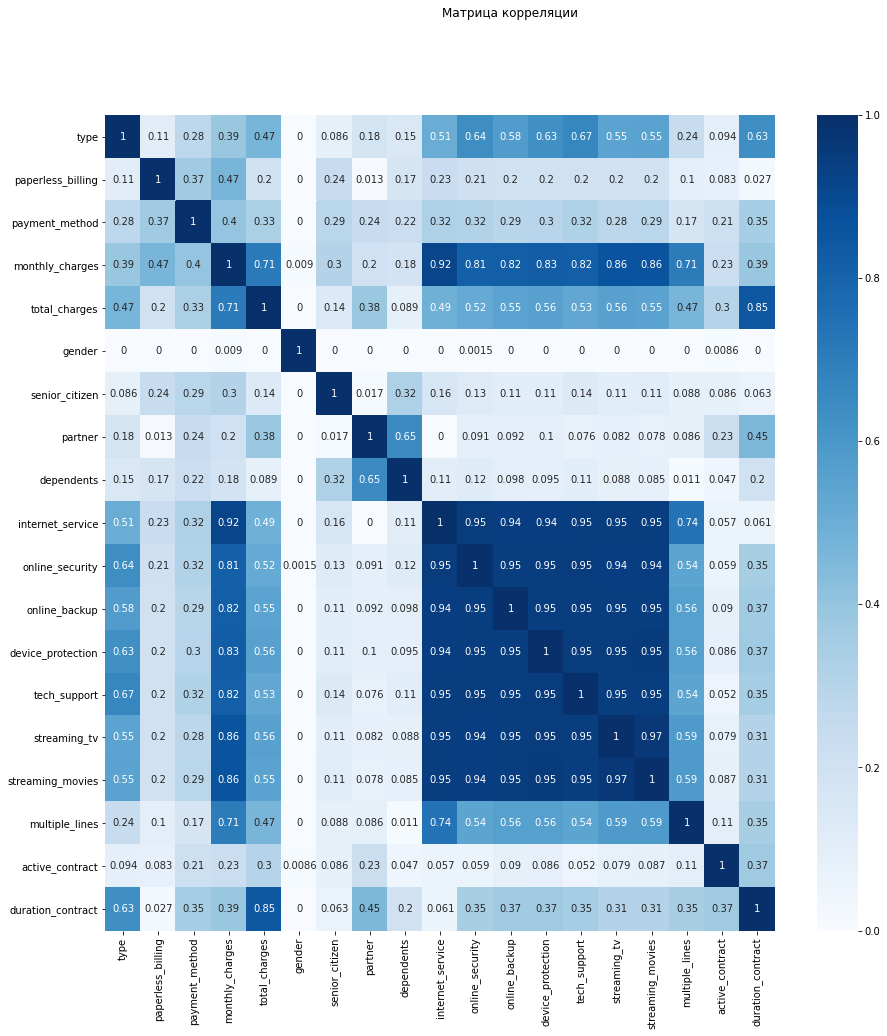

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.suptitle('Матрица корреляции')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Blues');

По матрице видим наличие мультиколлениарности. Уберём все значения > 0.9.

Также, отберём показатели коррелирующие с целевым показателем active_contract:
- duration_contract (0.37)
- total_charges (0.3)
- monthly_charges (0.23)
- partner (0.23)
- payment_method (0.21)
- multiple_lines (0.11)
- type (0.094)
- online_backup (0.09)

In [ ]:
df.drop(['paperless_billing', 'gender', 'senior_citizen',
         'dependents', 'internet_service', 'online_security', 'device_protection',
         'tech_support', 'streaming_tv', 'streaming_movies'], axis=1, inplace=True)

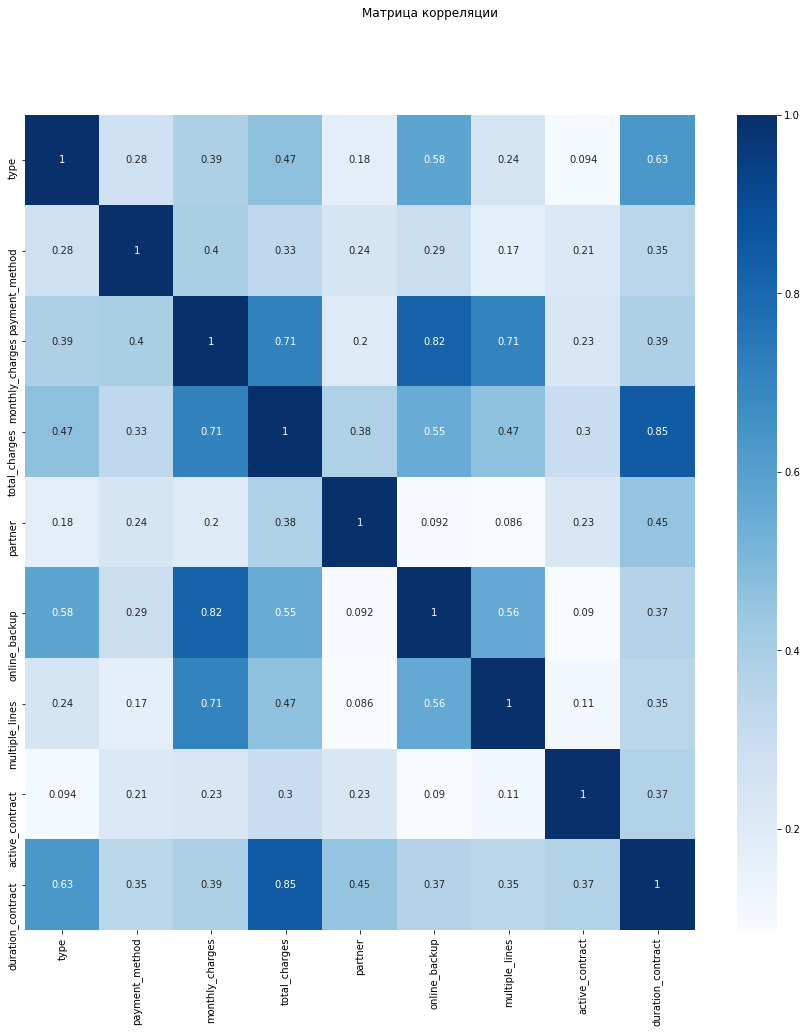

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.suptitle('Матрица корреляции')
sns.heatmap(df.phik_matrix(interval_cols=interval_cols), annot=True, cmap='Blues');

Вывод по корреляционному анализу:
- customer_id прреобразовали в индекс;
- отобрали 8 показателей, которые сильнее остальных коррелируют с целевым показателем.

**Анализ числовых признаков:**

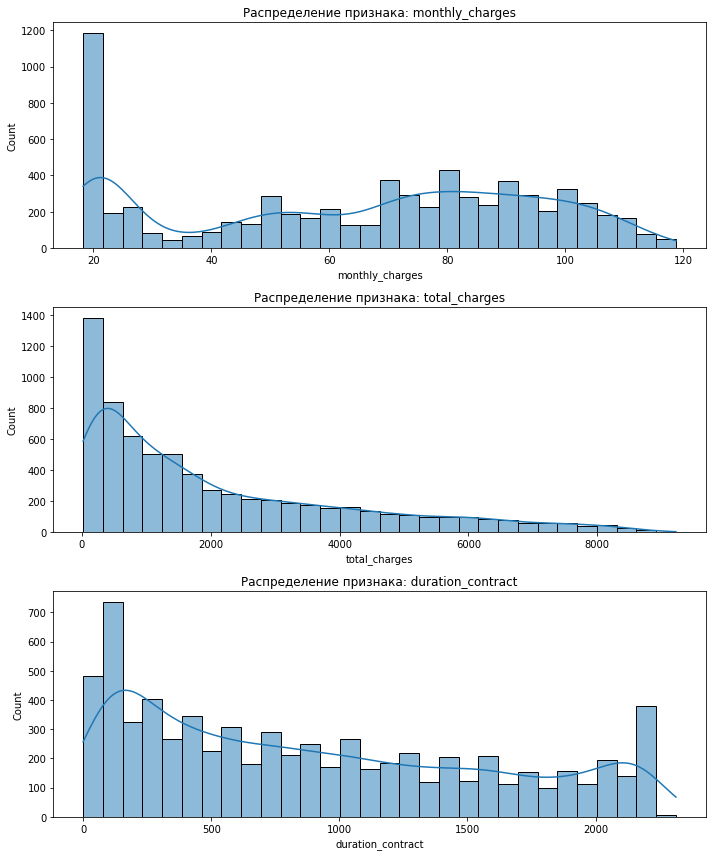

In [ ]:
fig, axs = plt.subplots(len(interval_cols), 1, figsize=(10, len(interval_cols)*4))
for i, col in enumerate(interval_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axs[i])
    axs[i].set_title(f'Распределение признака: {col}')
plt.tight_layout()
plt.show()

`monthly_chargers:`

Большинство пользователей имеют небольшие ежемесячные расходы, при этом количество людей с расходами в диапазоне средних значений примерно одинаково. Лица с самыми наибольшими расходами за месяц встречаются очень редко.

`total_chargers:`

Количество абонентов уменьшается по мере роста его общих расходов.

`duration_contract:`

При рассмотрении длительности контракта видим, что пики наблюдаются среди относительно новых пользователей, а также среди тех, кто пользуется услугами длительный период. Если новый пользователь разочаровывается и уходит, то к определенному сроку количество активных сокращается; в то же время есть пользователи, которых всё устраивает, и они продолжают пользоваться услугами длительное время.

**Анализ категориальных признаков:**

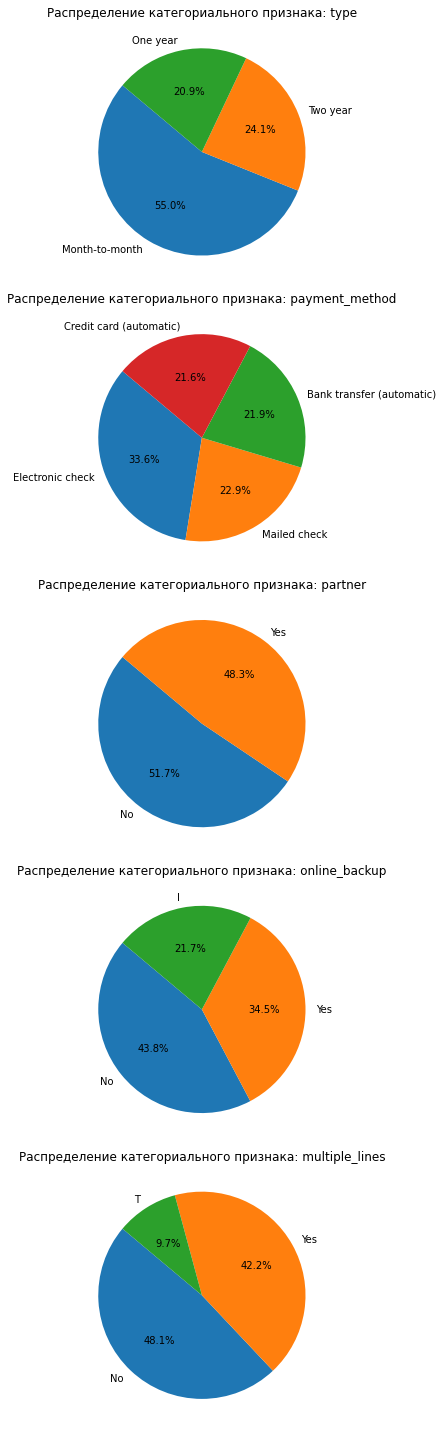

In [ ]:
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
fig, axs = plt.subplots(len(cat_cols), 1, figsize=(12, len(cat_cols)*4))

if len(cat_cols) == 1:
    axs = [axs]

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()
    labels = counts.index
    sizes = counts.values

    axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(f'Распределение категориального признака: {col}')

plt.tight_layout()
plt.show()

`type:`
Типа оплаты. Большинство пользователей (55%) платят раз в месяц.

`payment_method`
Тип платежа. Методы платежа распределены практически поровну: Electronic check 33,6%, остальные 21-23%.

`partner`
Чуть больше пользователей (51,7%), у которых нет супруга/супруги.

`online_backup`
У большинства (43,8%)отсутствует облачное хранилище файлов для резервного копирования данных.

`multiple_lines:`
48,1% абонентов не имеют подключение телефона к нескольким линиям одновременно.

# 5.  Подготовка данных

In [ ]:
cat_col_names = ['type', 'payment_method', 'partner', 'online_backup', 'multiple_lines']
num_col_names = ['monthly_charges', 'total_charges', 'duration_contract']
df[cat_col_names] = df[cat_col_names].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   payment_method     7043 non-null   category
 2   monthly_charges    7043 non-null   float64 
 3   total_charges      7043 non-null   float64 
 4   partner            7043 non-null   category
 5   online_backup      7043 non-null   category
 6   multiple_lines     7043 non-null   category
 7   active_contract    7043 non-null   float64 
 8   duration_contract  7043 non-null   int64   
dtypes: category(5), float64(3), int64(1)
memory usage: 310.2+ KB


In [ ]:
X = df.drop(columns=['active_contract'])
y = df['active_contract']
RANDOM_STATE = 61025

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,
    random_state=RANDOM_STATE
)
print('train/test = ', round(X_train.shape[0] / X.shape[0], 2), '/', round(X_test.shape[0] / X.shape[0], 2))

train/test =  0.75 / 0.25


In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_col_names),
     ('num', StandardScaler(), num_col_names)
    ],
    remainder='passthrough'
)

# 6. Обучение моделей машинного обучения

#### RandomForestClassifier

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models__max_depth': range(4, 21, 4),
        'models__min_samples_leaf': range(1, 11, 1),
        'models__n_estimators': [10, 50, 100],
        'models__class_weight' : [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

    }

]

rfc = RandomizedSearchCV(
                         pipe_final,
                         param_grid,
                         cv=5,
                         scoring='roc_auc',
                         random_state=RANDOM_STATE,
                         n_jobs=-1,
                         verbose=3
).fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rfc.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на крос валидации:', rfc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END models__class_weight=None, models__max_depth=4, models__min_samples_leaf=2, models__n_estimators=100, preprocessor__num=StandardScaler();, score=0.784 total time=   0.4s
[CV 2/5] END models__class_weight=None, models__max_depth=4, models__min_samples_leaf=2, models__n_estimators=100, preprocessor__num=StandardScaler();, score=0.826 total time=   0.4s
[CV 3/5] END models__class_weight=None, models__max_depth=4, models__min_samples_leaf=2, models__n_estimators=100, preprocessor__num=StandardScaler();, score=0.823 total time=   0.3s
[CV 4/5] END models__class_weight=None, models__max_depth=4, models__min_samples_leaf=2, models__n_estimators=100, preprocessor__num=StandardScaler();, score=0.808 total time=   0.3s
[CV 5/5] END models__class_weight=None, models__max_depth=4, models__min_samples_leaf=2, models__n_estimators=100, preprocessor__num=StandardScaler();, score=0.800 total time=   0.3s
[CV 1/5] END models__cla

#### LGBMClassifier

In [ ]:
lgb_model = LGBMClassifier(random_state=RANDOM_STATE)

lgbm_params = {
               'learning_rate': [0.0005, 0.001, 0.01, 0.05, 0.1],
               'n_estimators': [100, 200, 300, 500],
               'num_leaves': [31, 71, 101, 151],
               'class_weight': [None, 'balanced']
              }

lgbmс = RandomizedSearchCV(lgb_model,
                           lgbm_params,
                           cv=5,
                           scoring='roc_auc',
                           random_state=RANDOM_STATE,
                           n_jobs=-1,
                           verbose=3
).fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', lgbmс.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на крос валидации:', lgbmс.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END class_weight=balanced, learning_rate=0.001, n_estimators=300, num_leaves=71;, score=0.773 total time=   5.5s
[CV 2/5] END class_weight=balanced, learning_rate=0.001, n_estimators=300, num_leaves=71;, score=0.792 total time=   5.7s
[CV 3/5] END class_weight=balanced, learning_rate=0.001, n_estimators=300, num_leaves=71;, score=0.809 total time=   5.9s
[CV 4/5] END class_weight=balanced, learning_rate=0.001, n_estimators=300, num_leaves=71;, score=0.796 total time=   7.0s
[CV 5/5] END class_weight=balanced, learning_rate=0.001, n_estimators=300, num_leaves=71;, score=0.803 total time=   7.5s
[CV 1/5] END class_weight=balanced, learning_rate=0.01, n_estimators=100, num_leaves=151;, score=0.785 total time=   5.5s
[CV 2/5] END class_weight=balanced, learning_rate=0.01, n_estimators=100, num_leaves=151;, score=0.800 total time=   3.7s
[CV 3/5] END class_weight=balanced, learning_rate=0.01, n_estimators=100, num_leaves=

#### CatBoostClassifier

In [ ]:
cbc_model = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=cat_col_names, verbose=50)

cbrm_params = {
               'max_depth': [4, 8],
               'learning_rate': [0.005, 0.01, 0.1],
               'n_estimators': [100, 200]
              }

cbc = RandomizedSearchCV(cbc_model,
                             cbrm_params,
                             cv=5,
                             scoring='roc_auc',
                             random_state=RANDOM_STATE,
                             n_jobs=-1,
                             verbose=3).fit(X_train, y_train)

print ('Метрика ROC-AUC лучшей модели на крос валидации:', cbc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6855830	total: 6.27ms	remaining: 1.25s
50:	learn: 0.4613844	total: 332ms	remaining: 969ms
100:	learn: 0.3904660	total: 552ms	remaining: 541ms
150:	learn: 0.3599663	total: 762ms	remaining: 247ms
199:	learn: 0.3444080	total: 961ms	remaining: 0us
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.804 total time=   1.7s
0:	learn: 0.6866118	total: 5.86ms	remaining: 1.17s
50:	learn: 0.4697950	total: 222ms	remaining: 647ms
100:	learn: 0.3988794	total: 421ms	remaining: 413ms
150:	learn: 0.3675835	total: 626ms	remaining: 203ms
199:	learn: 0.3519553	total: 824ms	remaining: 0us
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.826 total time=   1.7s
0:	learn: 0.6859678	total: 5.74ms	remaining: 1.14s
50:	learn: 0.4671598	total: 232ms	remaining: 678ms
100:	learn: 0.3892812	total: 456ms	remaining: 447ms
150:	learn: 0.3623588	total: 650ms	remaining: 211ms
199:	learn: 0.3476263	total: 

# 7. Выбор лучшей модели

In [ ]:
results = pd.DataFrame({'Model': ['RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier'],
                        'ROC_AUC_Valid': [rfc.best_score_, lgbmс.best_score_, cbc.best_score_],
                        'Cod':['rfc','lgbmс','cbc']})
results

,Model,ROC_AUC_Valid,Cod
0,RandomForestClassifier,0.821062,rfc
1,LGBMClassifier,0.880835,lgbmс
2,CatBoostClassifier,0.868201,cbc


In [ ]:
results = results[results['ROC_AUC_Valid']>=0.85].sort_values('ROC_AUC_Valid', ascending=False).head(1)
results

,Model,ROC_AUC_Valid,Cod
1,LGBMClassifier,0.880835,lgbmс


In [ ]:
best_model_name = results.iloc[0]['Cod']

In [ ]:
if best_model_name == 'rfc':
    best_model = rfc.best_estimator_
elif best_model_name == 'lgbmс':
    best_model = lgbmс.best_estimator_
elif best_model_name == 'cbc':
    best_model = cbc.best_estimator_

In [ ]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f'ROC-AUC на тестовых данных: {roc_auc_test:.3f}')

ROC-AUC на тестовых данных: 0.900


Матрица ошибок:
 [[1424   72]
 [  90  175]]


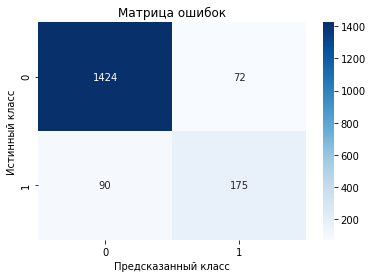

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
print('Матрица ошибок:\n', cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

- Точность (Accuracy). Верно классифицированных образцов: 1599. Точность: 90,8%.
- Класс positives (положительный класс). Истинных положительных (TP): 175. Ложно отрицательных (FN): 90.
- Класс negatives (отрицательный класс). Истинных отрицательных (TN): 1424. Ложно положительных (FP): 72.


*Основные показатели:*

- Точность (Precision). Для положительного класса: TP / (TP + FP) = 70,8%.
- Полнота (Recall). Для положительного класса: TP / (TP + FN) = 66,1%.


*Вывод по матрице ошибок:*

Модель показывает достаточно хорошие результаты с точностью около 90,8%, однако при этом полнота и точность для положительного класса составляют около 66-70%, что свидетельствует о наличии некоторого количества пропущенных положительных случаев и ложных срабатываний. Это говорит о необходимости возможной донастройки модели для улучшения ее чувствительности и точности по позитивному классу.

In [ ]:
print('Отчёт классификации:\n', classification_report(y_test, y_test_pred))

Отчёт классификации:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      1496
         1.0       0.71      0.66      0.68       265

    accuracy                           0.91      1761
   macro avg       0.82      0.81      0.81      1761
weighted avg       0.91      0.91      0.91      1761



- Общая точность (accuracy) — 91%: модель правильно классифицирует около 91% всех случаев на тестовой выборке.
- Чувствительность (recall) для класса 0 — 95%: модель почти всегда правильно обнаруживает случаи отрицательного класса.
- Чувствительность (recall) для класса 1 — 66%: модель обнаруживает около двух третей положительных случаев, что довольно неплохо, но есть вероятность пропуска некоторых положительных образцов.
- F1-score для класса 0 — 0.95, что означает хорошую гармонию между точностью и полнотой для отрицательного класса.
- F1-score для класса 1 — 0.68, что ниже и говорит о том, что модель менее хорошо справляется с позитивным классом.

Модель показывает хорошую точность и высокую эффективность в распознавании отрицательных случаев, однако для позитивного класса есть некоторое снижение метрик, особенно в части чувствительности и F1-score.

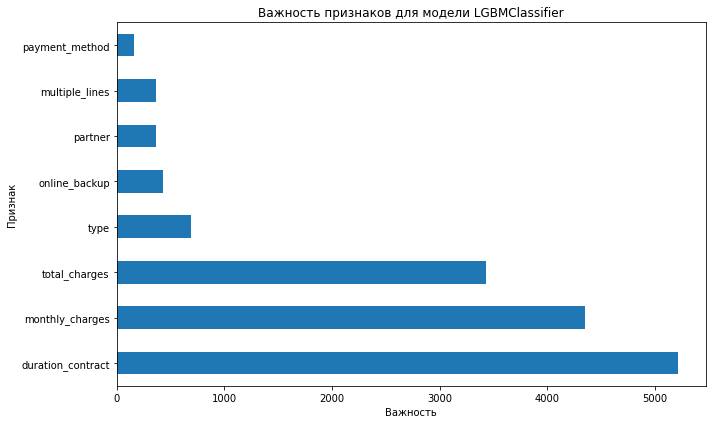

In [ ]:
best_model = lgbmс.best_estimator_
importances = best_model.feature_importances_

pd.Series(importances, index=X_train.columns) \
  .sort_values(ascending=False) \
  .plot(kind='barh', figsize=(10, 6))

plt.title('Важность признаков для модели LGBMClassifier')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Для оценки качества модели использовали показатель AUC-ROC с порогом >= 0.85.

Обучались на моделях:
- RandomForestClassifier;
- LGBMClassifier;
- CatBoostClassifier.

Лучшая модель:
- LGBMClassifier(class_weight='balanced', n_estimators=500, random_state=61025)
- Метрика ROC-AUC лучшей модели на крос валидации: 0.8808347647925292

Наиболее важные признаки:
- duration_contract - cрок действия контракта;
- monthly_charges - расходы за месяц;
- total_charges - общие расходы абонента;

Наименее важные признаки:
- payment_method - тип платежа;
- multiple_lines - подключение телефона к нескольким линиям одновременно.;
- partner - есть ли у абонента супруг или супруга.

# 8. Общий вывод и рекомендации заказчику

Оператор связи «ТелеДом» борится с оттоком клиентов. Цель проекта - создать модель для прогноза оттока клиентов.

В ходе работы проведена подготовка и анализ данных, подбор моделей и гиперпараметров. В результате была выбрана и обучена лучшая модель - `LGBMClassifier` с параметрами `class_weight='balanced', n_estimators=500`, отражающая высокую эффективность (ROC-AUC на кросс-валидации около 0.881).

**Наиболее важные признаки, влияющие на отток:**
- duration_contract — срок действия контракта;
- monthly_charges — ежемесячные расходы;
- total_charges — общие затраты клиента.

**Менее значимыми факторами оказались:**
- payment_method — способ оплаты;
- multiple_lines — наличие нескольких линий связи;
- partner — наличие супруга или супруги.

Основные факторы риска оттока — длительность контракта и расходы клиента. Это говорит о необходимости разработать персонализированные предложения и специальные условия для удержания новых и постоянных клиентов с высоким риском ухода.
Наименее важные признаки — информация о способе оплаты и семейном положении. Их влияние небольшое, поэтому их можно учитывать в меньшей степени при формировании стратегии.

**Рекомендации:**
- Приложить усилия к стимулированию длительности контрактов и снижению ежемесячных затрат клиентов.
- Разработать промо-акции или бонусы для клиентов с короткими контрактами.
- Использовать модель для раннего выявления потенциальных ушедших клиентов и своевременно предлагать им специальные условия и программы лояльности.